### Import & init

In [1]:
# imports and shit
import numpy as np
import PIL.Image as Image

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import timm
from selectivesearch import selective_search
import xml.etree.ElementTree as ET
import json

os.chdir('/Users/andreastheilgaard/Desktop/deep-learning-in-computer-vison/')
#os.chdir('/zhome/0a/0/137912/mihai/deep-learning-in-computer-vison')
datapath = "data/Potholes/"

with open(f"{datapath}splits.json") as json_data:
    data = json.load(json_data)

from tqdm import tqdm
from omegaconf import OmegaConf
import cv2
config = OmegaConf.create({
    'size': 512, # org size mean 575 x 766
    'batch_size': 4, #4#6
    'seed': 42,
    'workers': 0, #3
})

/Users/andreastheilgaard/opt/anaconda3/envs/CV/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
def read_content(name: str):
    tree = ET.parse(f"{datapath}annotated-images/{name}.xml")
    root = tree.getroot()
    img = Image.open(f"{datapath}annotated-images/{name}.jpg")
    list_with_all_boxes = []

    for boxes in root.iter('object'):
        # filename = root.find('filename').text
        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return list_with_all_boxes, img

class Potholes(torch.utils.data.Dataset):
    def __init__(self,split,transform=None,config=None):
        self.transform = transform
        self.split = split
        self.box_transformer = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.split)

    def __getitem__(self, idx):
        boxes, img = read_content(name=self.split[idx])
        #img = img/255
        # original_height, original_width, _ = np.array(img).shape
        # img_resized = self.transform(img)
        # x_scale = config.size / original_width
        # y_scale = config.size / original_height
        # scaled_bboxes = [[x1 * x_scale, y1 * y_scale, x2 * x_scale, y2 * y_scale] for x1, y1, x2, y2 in boxes]
        # if len(scaled_bboxes) != 19:
        #     iters = 19-len(scaled_bboxes)
        #     for _ in range(iters):
        #         scaled_bboxes.append([-1,-1,-1,-1])
        img = self.transform(img)
        boxes = self.box_transformer(np.array(boxes))
        index = int(self.split[idx].split('-')[1])
        return index,img,boxes.numpy()[0]       
        #boxes= self.box_transformer(np.array(scaled_bboxes))
        #return idx, img_resized, boxes.numpy()[0]
        #return img,boxes

def batch_collater(batch):
    return tuple(zip(*batch))

def get_data(traindata,testdata):
    size = config.size
    #transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()])
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = Potholes(split=traindata,transform=transform,config=config)
    testset = Potholes(split=testdata,transform=transform,config=config)
    train_loader = DataLoader(trainset, batch_size=config.batch_size, shuffle=True, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed),collate_fn=batch_collater)
    test_loader = DataLoader(testset, batch_size=config.batch_size, shuffle=False, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed),collate_fn=batch_collater)

    return train_loader,test_loader

def get_sizes(train_loader):
    img_width_list = []
    img_height_list = []
    for batch in train_loader:
        img,_ = batch
        img_width_list.append(img.shape[2])
        img_height_list.append(img.shape[3])
    return np.mean(img_width_list), np.mean(img_height_list)

def extract_box(box):
    # img bs,3,H,W  , box, bs,1,19,4
    #img,box = batch
     # img bs,3,H,W  , box [#object_box,4]
    return [box[x][box[x]!=-1].reshape(-1,4).numpy() for x in range(config.batch_size)]

def plot_img_and_box(img,box_list,gt=None,clss=None,linewidth=3,bg=True):
    if torch.is_tensor(box_list): box_list = extract_box(box_list)
    if torch.is_tensor(img[0]): img = [i.permute(1,2,0) for i in img]
    if isinstance(img,tuple): img = [i.permute(1,2,0) for i in img]
    n = len(box_list)
    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(8*n, 8),dpi=100)
    if n==1: 
        ax = [ax]
    for i,boxes in enumerate(box_list):
        ax[i].imshow(img[i])
        ax[i].set_axis_off()
        if gt is not None:
            if torch.is_tensor(gt): gt = [g[0] for g in gt]
            for gtcount,(x1,y1,x2,y2) in enumerate(gt[i]):
                ax[i].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=linewidth*3, edgecolor=(0,1,0), facecolor='none'))
            ax[i].add_patch(patches.Rectangle((0,0),0,0, label=f'Ground truth ({gtcount+1})', linewidth=linewidth*3, edgecolor=(0,1,0), facecolor='none'))
        
        if clss is None:
            for boxcount,(x1,y1,x2,y2) in enumerate(boxes):
                ax[i].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=linewidth, edgecolor=(1,0,0), facecolor='none'))
            ax[i].add_patch(patches.Rectangle((0,0),0,0, label=f'Candidates ({boxcount+1})', linewidth=linewidth, edgecolor=(1,0,0), facecolor='none'))

        else:
            lbls = [f'Background ({clss[i].count(0)})',f'Pothole ({clss[i].count(1)})']
            for idx,(x1,y1,x2,y2) in enumerate(boxes):
                label = clss[i][idx]
                if bg or label==1:
                    ax[i].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=linewidth, edgecolor=(label,0,1-label), facecolor='none'))
            ax[i].add_patch(patches.Rectangle((0,0),0,0, label=lbls[0], linewidth=linewidth, edgecolor=(0,0,1-0), facecolor='none'))
            ax[i].add_patch(patches.Rectangle((0,0),0,0, label=lbls[1], linewidth=linewidth, edgecolor=(1,0,1-1), facecolor='none'))
            
        ax[i].legend(bbox_to_anchor =(0.5,-0.1), loc='lower center',ncol=3)
        ax[i].set_aspect("equal", adjustable="box")

# def extract_candidates_old(images):
#     min_candidate_scale = 0.05
#     max_candidate_scale = 1
#     batch_candidates = []
#     for i in range(config.batch_size):
#         img = images[i]
#         if torch.is_tensor(img) == 3:
#             img = img.permute(1,2,0)
#         img_lbl, regions = selective_search(img, scale=1,sigma=0.8, min_size=100)

#         img_area = np.prod(img.shape[:2])
#         candidates = []
#         for r in regions:
#             if r['rect'] in candidates: continue
#             if r['size'] < (min_candidate_scale*img_area): continue
#             if r['size'] > (max_candidate_scale*img_area): continue
#             x1, y1, w, h = r['rect']
#             x2 = w+x1
#             y2 = h+y1
#             candidates.append(list([x1,y1,x2,y2]))
#         batch_candidates.append(candidates)
#     return batch_candidates

def extract_candidates(images):
    batch_candidates = []
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    for i in range(config.batch_size):
        img = images[i]
        if img.shape[0] == 3:
            img = img.permute(1,2,0).numpy()
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        result_list = []
        for x1,y1,w,h in ssresults:
            x2=x1+w
            y2=y1+h
            result_list.append([x1,y1,x2,y2])
        batch_candidates.append(result_list)
    return batch_candidates

def get_iou(boxA, boxB, epsilon=1e-5):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = (interArea / float(boxAArea + boxBArea - interArea))
    return iou

### Datasplit

In [27]:
traindata = [(x.split('.'))[0] for x in data['train']]
testdata = [(x.split('.'))[0] for x in data['test']]
train_loader,test_loader = get_data(traindata=traindata,testdata=testdata)
#indicies, images,boxes = next(iter(train_loader))
#candidates = extract_candidates(images) #extract_candidates(images) 
#ground_t = boxes

In [26]:
indicies

(409, 184, 475, 418)

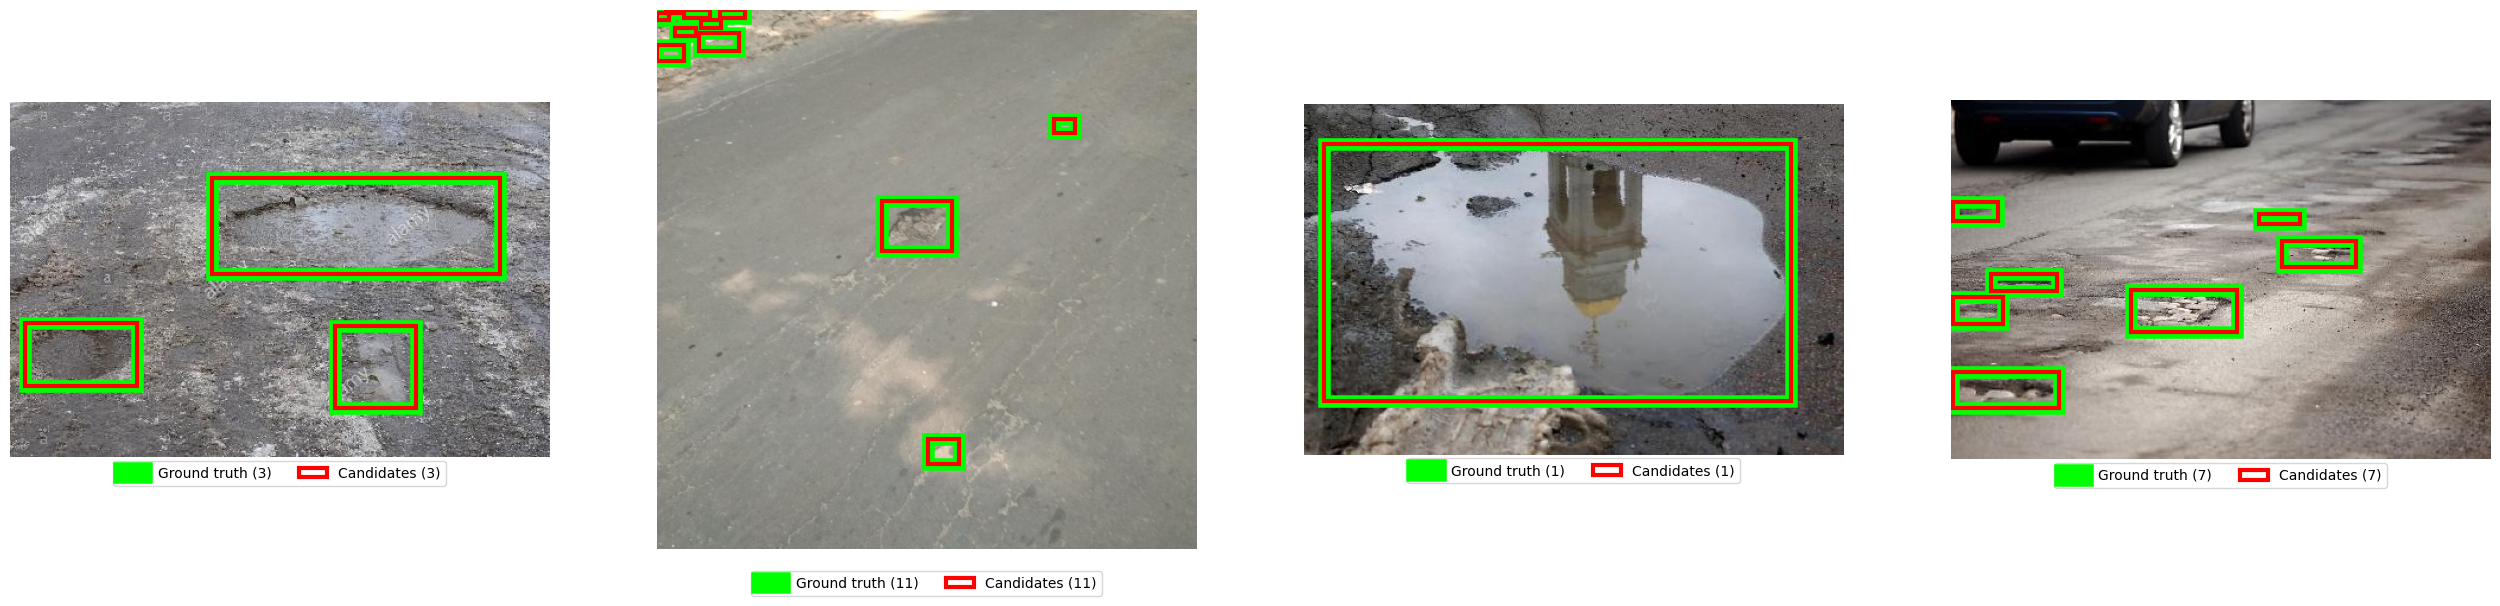

In [43]:
plot_img_and_box(images, boxes, gt=ground_t)

In [5]:
def assign_candidate_label(ground_t, candidates, extend_gound_truth=True, thres=0.5):
    # W, H = config.size, config.size
    ext_candidates, ext_clss = [], []
    for batch_idx in range(config.batch_size): # iterate over batch
        clss, best_iou = [], []
        candidate_boxes = candidates[batch_idx]
        ground_truth_boxes = ground_t[batch_idx]

        for candidate in candidate_boxes:
            candidate_ious = np.array([get_iou(candidate, gt_box) for gt_box in ground_truth_boxes])
            idx = np.argmax(candidate_ious)
            best_iou.append(candidate_ious[idx])
            #best_bb = ground_truth_boxes[idx]
            #print(candidate_ious)
            #print(candidate_ious[idx])
            if candidate_ious[idx] > thres:
                clss.append(1)
                # x, _y, _X, _Y = best_bb
                # x, cy, cX, cY = candidate_ious[idx]
                # delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
                # deltas.append(delta)
            else: 
                clss.append(0)     
            #rois.append(np.array(candidate) / np.array([W, H, W, H]))
        
        if extend_gound_truth:
            for gt_box in ground_truth_boxes:
                candidate_boxes.append(list(gt_box))
                clss.append(1)
        
        ext_clss.append(clss)
        ext_candidates.append(candidate_boxes)

    return ext_candidates, ext_clss

In [6]:
X,Y = assign_candidate_label(ground_t,candidates,thres=0.5)

In [ ]:
ground_t[-1]

In [ ]:
X[-1][-1:]

In [10]:
[X[0][-1:]]

[[274, 189, 342, 258]]

In [19]:
X[0][-1]

[274, 189, 342, 258]

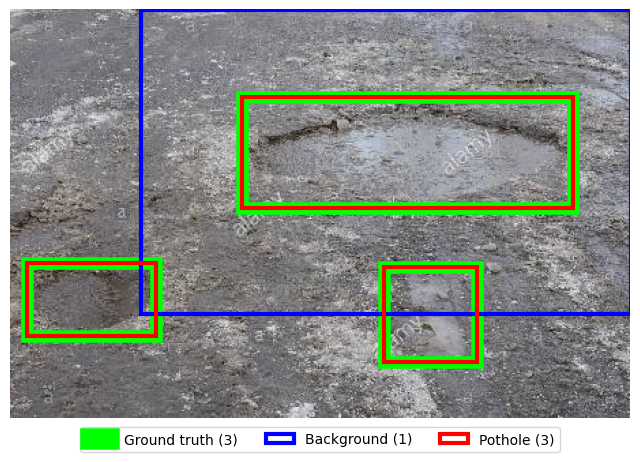

In [44]:
plot_img_and_box(images[0:1], [X[0][-4:]], gt=[ground_t[0][:]],clss=[Y[0][-4:]])

In [28]:
proposed_boxes_train = {}
# #for batch in tqdm(train_loader):
indicies, images,boxes = next(iter(train_loader))
candidates = extract_candidates(images) #extract_candidates(images) 
ground_t = boxes
X,Y = assign_candidate_label(ground_t,candidates,thres=0.5)
for i,index in enumerate(indicies):
    proposed_boxes_train[index] = {'proposed_box':X[i],'labels':Y[i]}

In [34]:
proposed_boxes_train

{409: {'proposed_box': [[273, 41, 367, 89],
   [366, 141, 455, 272],
   [16, 240, 64, 266],
   [304, 42, 335, 63],
   [192, 81, 416, 134],
   [431, 122, 455, 154],
   [256, 144, 320, 176],
   [0, 271, 32, 290],
   [170, 225, 209, 300],
   [49, 72, 73, 103],
   [85, 97, 126, 135],
   [272, 145, 320, 175],
   [248, 47, 271, 78],
   [58, 96, 96, 143],
   [204, 287, 225, 300],
   [305, 289, 320, 300],
   [144, 272, 191, 300],
   [89, 224, 96, 240],
   [352, 192, 417, 300],
   [48, 288, 64, 300],
   [177, 16, 255, 62],
   [161, 273, 179, 300],
   [326, 161, 336, 176],
   [417, 97, 431, 110],
   [256, 122, 319, 142],
   [289, 65, 303, 78],
   [210, 149, 288, 183],
   [251, 209, 288, 300],
   [368, 289, 384, 300],
   [58, 81, 111, 160],
   [365, 79, 400, 86],
   [154, 121, 167, 132],
   [343, 177, 351, 191],
   [208, 50, 251, 80],
   [46, 237, 63, 247],
   [401, 80, 447, 99],
   [248, 47, 271, 80],
   [193, 240, 272, 272],
   [273, 41, 389, 90],
   [0, 54, 91, 122],
   [351, 121, 415, 166],
 

In [ ]:
plt.imshow(images[3].permute(1,2,0))

In [ ]:
plot_img_and_box(images[], boxes, gt=ground_t)

In [35]:
import pandas as pd
Export = True

if Export:
    df = pd.DataFrame(proposed_boxes_train)
    df.to_json('train.json')
else:
    new_df = pd.read_json('train.json')
    A = new_df.to_dict()

### Now 'train' loop

In [ ]:
proposed_boxes_train[241]['proposed_box'][-1]

## Datalaoder

In [64]:
def load_dict(type_):
    df = pd.read_json(f"{type_}.json")
    return df.to_dict()

def reblance(Y,factor:int=4):
    true_counts = sum(Y)
    background_idx = np.random.choice(np.where(np.array(Y)==0)[0],size=true_counts*factor)
    pothole_idx = np.where(np.array(Y)==1)[0]
    return np.concatenate(((background_idx,pothole_idx))) 

config2 = OmegaConf.create({
    'size': 512, # org size mean 575 x 766
    'prop_size': 64,
    'batch_size': 4, #4#6
    'seed': 42,
    'workers': 0, #3
})

In [31]:
w, h = [], []
for p_idx in range(len(A)):
    p_box = A[p_idx]['proposed_box']
    
    for box in p_box:
        w.append(abs(box[0] - box[2]))
        h.append(abs(box[3] - box[1]))

print(f"Width:  mean: {np.mean(w)}  median: {np.median(w)}")
print(f"Height: mean: {np.mean(h)}  median: {np.median(h)}")

NameError: name 'A' is not defined

In [65]:
class Potholes2(torch.utils.data.Dataset):
    def __init__(self, split, train=True, transform=None, config=None):
        self.transform = transform
        self.split = split
        self.box_transformer = transforms.Compose([transforms.ToTensor()])
        self.propose_transform = transforms.Compose([transforms.Resize((config2.prop_size,config2.prop_size))])
        self.train = train
        self.proposed_box_dict = load_dict('train') if train else load_dict('test')

    def __len__(self):
        return len(self.split)

    def __getitem__(self, idx):
        boxes, img = read_content(name=self.split[idx])
        #img = img/255
        # original_height, original_width, _ = np.array(img).shape
        # img_resized = self.transform(img)
        # x_scale = config.size / original_width
        # y_scale = config.size / original_height
        # scaled_bboxes = [[x1 * x_scale, y1 * y_scale, x2 * x_scale, y2 * y_scale] for x1, y1, x2, y2 in boxes]                
        GT = self.box_transformer(np.array(boxes))
        img = self.box_transformer(img) # only transform to tensor

        index = int(self.split[idx].split('-')[1])
        proposed_boxes = self.proposed_box_dict[index]['proposed_box']
        labels = self.proposed_box_dict[index]['labels']
        balance_idx = reblance(labels)
        labels = np.array(labels)[balance_idx]
        proposed_boxes = np.array(proposed_boxes)[balance_idx]
        
        # image crops of different sizes
        #self.propose_transform(
        img_proposals = [(img[:,int(x1):int(x2), int(y1):int(y2)]) for y1,x1,y2,x2 in proposed_boxes]
        img_proposals = [self.propose_transform(img[:,int(x1):int(x2), int(y1):int(y2)]) for y1,x1,y2,x2 in proposed_boxes]
        #img_proposals = [self.propose_transform(img[:,int(x1):int(x2), int(y1):int(y2)]) for x1,y1,x2,y2 in proposed_boxes]
        # img_resized: 1 resized picture
        # proposed_boxes: boxes representing image proposals in image size domain
        # img_proposals: crops of image representing different image proposals of equl size
        # labels: list of labels for each crop in img_proposals
        # boxes: GT of img_resized
        return index, img,proposed_boxes,img_proposals,labels,GT

def get_data2(traindata,testdata):
    size = config2.size
    transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()])
    trainset = Potholes2(split=traindata, train=True, transform=transform,config=config)
    #testset = Potholes2(split=testdata, train=False, transform=transform,config=config)
    train_loader = DataLoader(trainset, batch_size=config.batch_size, shuffle=True, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed),collate_fn=batch_collater)
    #test_loader = DataLoader(testset, batch_size=config.batch_size, shuffle=False, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed),collate_fn=batch_collater)
    return train_loader, None #test_loader

In [ ]:
A[122]['proposed_box'][-1]

In [ ]:
indicies

In [ ]:
plt.imshow(im_org[1][:,257:286,406:430].permute(1,2,0))

In [ ]:
plot_img_and_box(im_org, proposed_boxes, gt=GT, clss=labels)

In [ ]:
(409, 184, 475, 418)

In [66]:
traindata2 = [(x.split('.'))[0] for x in data['train']]
testdata2 = [(x.split('.'))[0] for x in data['test']]
#train_loader2, test_loader2 = get_data2(traindata=traindata2, testdata=testdata2)
train_loader2, test_loader2 = get_data2(traindata=['img-409','img-184','img-475','img-418'], testdata=testdata2)
indicies,im_org, proposed_boxes,im_prop,labels, GT = next(iter(train_loader2))

/Users/andreastheilgaard/opt/anaconda3/envs/CV/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [74]:
len(im_prop[0])

80

In [82]:
labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [89]:
XXXX = torch.vstack([x.unsqueeze(0) for x in im_prop[0]])
PERMUTATIONS = torch.randperm(XXXX.shape[0])
XXXX = XXXX[PERMUTATIONS,:]
LABELS = labels[0][PERMUTATIONS]
y_hat = model(XXXX)
loss = loss_fn(y_hat,LABELS)




In [90]:
LABELS

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [86]:
XXXX[torch.randperm(XXXX.shape[0]),:].shape

torch.Size([80, 3, 64, 64])

In [77]:
torch.vstack(im_prop[0])

torch.Size([240, 64, 64])

In [75]:
#for batch in train_loader
torch.cat(im_prop[0],dim=).shape

torch.Size([3, 5120, 64])

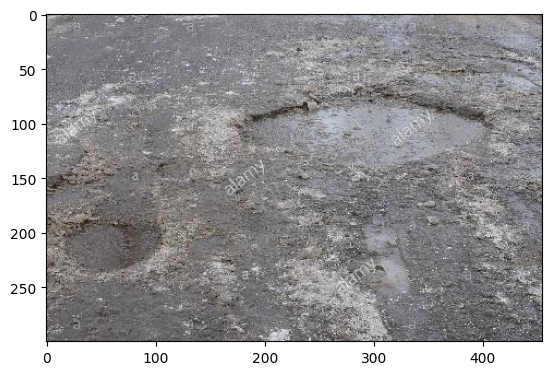

In [58]:
plt.imshow(im_org[0].permute(1,2,0))

In [45]:
proposed_boxes[0][-1]

array([274, 189, 342, 258])

In [52]:
im_org[0].shape

torch.Size([3, 300, 455])

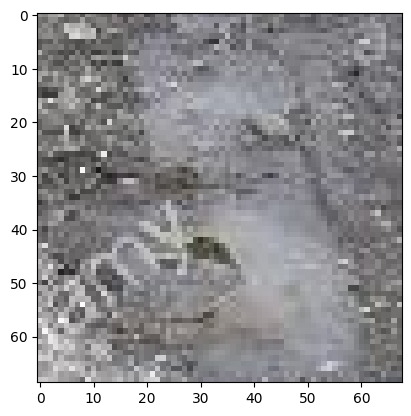

In [59]:
plt.imshow(im_org[0][:,189:258,274:342].permute(1,2,0))

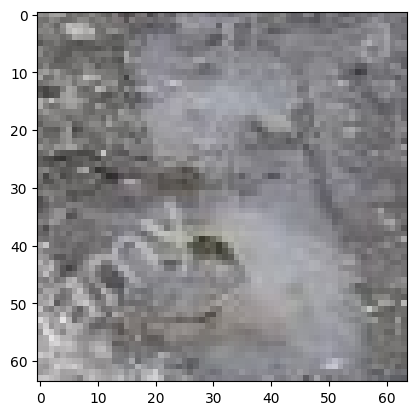

In [67]:
plt.imshow(im_prop[0][-1].permute(1,2,0))

In [38]:
proposed_boxes[0][-1]

array([274, 189, 342, 258])

In [ ]:
proposed_boxes[0]

In [ ]:
indicies

In [ ]:
proposed_boxes[3]

In [ ]:
proposed_boxes_train[241]

In [ ]:
proposed_transform = transforms.Compose([transforms.Resize((config2.prop_size,config2.prop_size))])
proposed_boxes[1][4]

In [ ]:
im_org[0][:,515:624,564:720]

In [ ]:
im_prop[1][4]

In [ ]:
proposed_transform((im_org[0][:,482:536, 6:45]))

In [ ]:
im_prop[0][-1]

In [ ]:
tra

In [ ]:
plt.imshow(im_org[0].permute(1,2,0))

In [ ]:
proposed_boxes[0][-1]

In [ ]:
plt.imshow(im_prop[0][-1].permute(1,2,0))

In [ ]:
indicies

In [ ]:
labels[0]

In [ ]:
plt.imshow(im_org[1].permute(1,2,0))

In [ ]:
plt.imshow(im_prop[1][-1].permute(1,2,0))

In [ ]:
len(im_prop[0])

In [ ]:
im_prop[0][0].shape

In [ ]:
sum(labels2[0][0])

In [ ]:
len(reblance(A[241]['labels']))

In [ ]:
np.random.choice(np.where(np.array(labels2[0][0])==0)[0],size=592)

In [ ]:
int(sum(labels2[0][0])*4)

In [ ]:
len(labels2[0][0])

In [ ]:
np.array(labels2[0][0])==0

In [ ]:
np.random.choice(np.array(labels2[0][0])==0,size=592)

In [ ]:
im_org[0].shape

## CNN Model

In [ ]:
class Pretrained(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.training_args = config.models.training
        if self.config.models.name == 'efficientnet':
            self.model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=2, drop_rate=self.training_args.dropout_rate if self.training_args.enable_dropout else 0)
            self.freeze_weights()

    def forward(self,x):
        return self.model(x)

    def freeze_weights(self):
        for param_name,param in self.model.named_parameters():
            if 'classifier' not in param_name:
                param.requires_grad = False
        
        self.model.classifier.requires_grad_()
